# Analyze the result of PARAMID-2

In [1]:
# load namespace
%run -i startup.py

Namespace: ['In', 'Out', 'cbs', 'db_ana', 'db_csv', 'db_raw', 'df_uid', 'exit', 'get_ipython', 'mpl', 'np', 'pd', 'plt', 'pymongo', 'quit', 'tp', 'utils', 'xr']


## Try no threshold

Intend to have a continuous distribution of grain on the map. Try no threshold in the `trackpy.locate`. Show results here.

In [3]:
# df = db_csv.get_df("60b56b30161f0a57434edb52")
# df = tp.filter_stubs(df, threshold=200)
# grouped = df.groupby("particle", sort=False)["mass"]
# largest_10 = grouped.sum().nlargest(10)
# sel_df = df[df["particle"].isin(largest_10.index)]

# oid = db_csv.insert(sel_df, {"source_id": "60b56b30161f0a57434edb52", "tag": "sliced dataframe"})
# oid

In [5]:
sel_df = db_csv.get_df("60b691d84523929818fb267d")
sel_grouped = sel_df.groupby("particle", sort=False)

In [6]:
image = np.zeros_like(np.load("data/PARAMID-2_background_1.npy"))

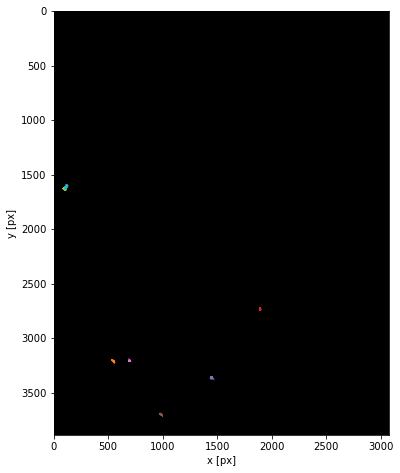

In [7]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111)
utils.set_real_aspect(ax)
tp.plot_traj(sel_df, ax=ax, superimpose=image);

The trajectories of the Bragg peaks on the detector. It doesn't move much.

In [8]:
def map_to_dist(data):
    return ((data["x"] - data["x"].mean()) ** 2 + (data["y"] - data["y"].mean()) ** 2).apply(np.sqrt)

In [9]:
def plot_hist_dist():
    stds = []
    names = []
    for name, group in sel_df.groupby("particle"):
        dist = map_to_dist(group)
        stds.append(dist.std())
        names.append(name)
        dist.plot.hist(bins=np.arange(0, 50, 1))
    plt.xlabel("deviation from average (pixel)")
    legends = ["{:05d}: {:3d}".format(int(n), int(s)) for n, s in zip(names, stds)]
    plt.legend(legends, title="std")
    return

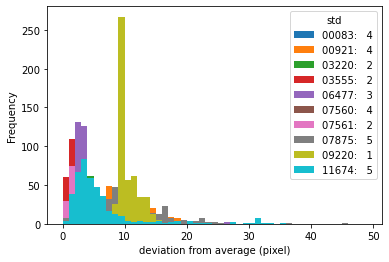

In [10]:
plot_hist_dist()

The range of the movement of the most of the Bragg peaks are in 20 pixels way.

In [11]:
altas = utils.create_atlas(sel_df)

In [12]:
altas

<xarray.Dataset>
Dimensions:   (dim_0: 181, dim_1: 27, grain: 10)
Coordinates:
  * dim_0     (dim_0) float64 0.0 0.25 0.5 0.75 1.0 ... 44.25 44.5 44.75 45.0
  * dim_1     (dim_1) float64 6.5 6.25 6.0 5.75 5.5 ... 1.0 0.75 0.5 0.25 0.0
  * grain     (grain) int64 83 921 3220 3555 6477 7560 7561 7875 9220 11674
Data variables:
    maps      (grain, dim_0, dim_1) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    y         (grain) float64 3.363e+03 3.211e+03 ... 1.632e+03 1.623e+03
    x         (grain) float64 1.445e+03 546.3 1.451e+03 ... 114.2 97.0 110.6
    mass      (grain) float64 3.549e+05 5.285e+05 ... 1.181e+05 2.408e+05
    size      (grain) float64 3.678 3.604 3.68 3.494 ... 3.345 3.046 2.588 2.899
    ecc       (grain) float64 0.1249 0.1114 0.1205 ... 0.1819 0.193 0.1534
    signal    (grain) float64 4.638e+03 7.423e+03 3.99e+03 ... 2.07e+03 5.61e+03
    raw_mass  (grain) float64 1.072e+06 1.287e+06 ... 2.839e+05 5.358e+05
    ep        (grain) float64 0.009514 0.0163 0.006942 ... 0.09445 0.008651

Get the grain maps of the 10 shiniest Brag peaks.

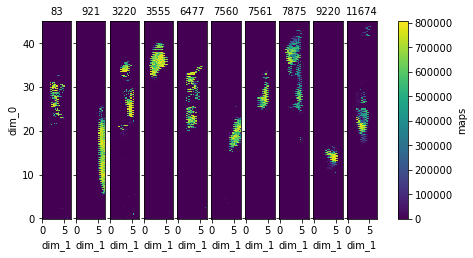

In [13]:
facet = utils.plot_grain_maps(altas)
facet.set_titles("{value}")
facet.fig.set_size_inches((6, 4))

The distribution of the grain. The area is not continuous. I guess that the `trackpy.link` probably separate the same peak to different tracks and that's why some pixels are missing and some of the (x, y) coords of the Bragg peaks are close to each other. Maybe using a fixed window on the image and calculating the mean intensity v.s frame sequence is a better idea. The window is selected by center +/- width: center is the mean (x, y) of the peak and the width is inferred from the mean size of the peak.

## Try the fixed window method

I tested the fixed window method on the first grain and compared it with the `trackpy.link` method. It seemed that the fixed window method looks more promising. To note that, this method is still based on `trackpy` because I need to know which are to set the small window on a large image.

In [14]:
uid = df_uid["uid"][0]
run = db_raw[uid]

# dask_array = run.xarray_dask()

# intensity = dask_array["dexela_image"][:, :, 3362-10:3362+10, 1444-10:1444+10].sum(axis=[1, 2, 3])
# intensity

# intensity = intensity.compute().to_netcdf("data/intensity_in_fixed_area.nc")

In [15]:
intensity = xr.load_dataarray("data/intensity_in_fixed_area.nc").to_dataset()
intensity.attrs = dict(run.start)
intensity = utils.reshape(intensity, "dexela_image")
intensity = (intensity - intensity.min()) * 0.2 # normalize

In [16]:
intensity2 = altas["maps"][0].drop("grain")
intensity3 = altas["maps"][4].drop("grain")

In [17]:
temp_atlas = xr.concat([intensity, intensity2, intensity3], dim="grain")
temp_atlas = temp_atlas.to_dataset(name="maps")

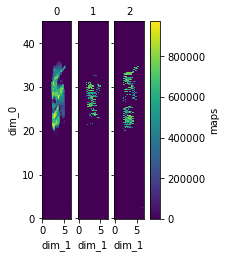

In [18]:
facet = utils.plot_grain_maps(temp_atlas)
facet.set_titles("{value}")
facet.fig.set_size_inches((2, 4))

The fig 0 is the result from fixed window method. It is the combination of two results from the `trackpy.link` because the window contains the two particles. I will try this further on all the 10 representative grains.